In [104]:
import pandas as pd

rates = pd.read_csv("../user_movie_rates.csv")
users = pd.read_csv("../users.csv")
movies = pd.read_csv("../movies.csv")

age_groups = pd.read_csv("../age_groups.csv")
occupations = pd.read_csv("../occupations.csv")

movie_genres = pd.read_csv("../movie_genres.csv")
genres = pd.read_csv("../genres.csv")

movie_actors = pd.read_csv("../movie_actors.csv")
actors = pd.read_csv("../actors.csv")

movie_directors = pd.read_csv("../movie_directors.csv")
directors = pd.read_csv("../directors.csv")

movie_countries = pd.read_csv("../movie_countries.csv")
countries = pd.read_csv("../countries.csv")

movie_tag = pd.read_csv("../movie_tag.csv")
tags = pd.read_csv("../tags.csv")

mpaa_rates = pd.read_csv("../mpaa_rates.csv")

print("rates:", rates.shape, rates.columns.tolist())
print("users:", users.shape, users.columns.tolist())
print("movies:", movies.shape, movies.columns.tolist())

print("age_groups:", age_groups.shape, age_groups.columns.tolist())
print("occupations:", occupations.shape, occupations.columns.tolist())

print("movie_genres:", movie_genres.shape, movie_genres.columns.tolist())
print("genres:", genres.shape, genres.columns.tolist())

print("movie_actors:", movie_actors.shape, movie_actors.columns.tolist())
print("actors:", actors.shape, actors.columns.tolist())

print("movie_directors:", movie_directors.shape, movie_directors.columns.tolist())
print("directors:", directors.shape, directors.columns.tolist())

print("movie_countries:", movie_countries.shape, movie_countries.columns.tolist())
print("countries:", countries.shape, countries.columns.tolist())

print("movie_tag:", movie_tag.shape, movie_tag.columns.tolist())
print("tags:", tags.shape, tags.columns.tolist())

print("mpaa_rates:", mpaa_rates.shape, mpaa_rates.columns.tolist())

rates: (948367, 4) ['user_id', 'movie_id', 'rating', 'datetime']
users: (6040, 4) ['user_id', 'gender', 'occupation', 'age_group_id']
movies: (3433, 7) ['movie_id', 'title', 'year', 'rated', 'plot', 'imdb_rating', 'imdb_id']
age_groups: (7, 2) ['group_id', 'group_label']
occupations: (21, 2) ['occ_id', 'occ_name']
movie_genres: (6408, 2) ['movie_id', 'genre_id']
genres: (18, 2) ['genre_id', 'name']
movie_actors: (10285, 2) ['movie_id', 'actor_id']
actors: (4965, 2) ['actor_id', 'actor']
movie_directors: (3676, 2) ['movie_id', 'director_id']
directors: (1918, 2) ['director_id', 'director']
movie_countries: (4765, 2) ['movie_id', 'country_id']
countries: (84, 2) ['country_id', 'country']
movie_tag: (450912, 2) ['movie_id', 'tag_id']
tags: (48075, 2) ['tag_id', 'tag_name']
mpaa_rates: (5, 2) ['rate_id', 'rate_name']


## Поведенческий портрет пользователя

Для каждого пользователя:
- сколько фильмов он оценил
- средняя оценка
- разброс оценок
- энтропия распределения оценок

In [ ]:
import numpy as np

rates_data = rates[["user_id", "movie_id", "rating"]].copy()
rates_data["rating"] = pd.to_numeric(rates_data["rating"])

user_basic = (
    rates_data.groupby("user_id")["rating"]
    .agg(
        num_ratings="count",
        mean_rating="mean",
        std_rating="std",
        median_rating="median",
        min_rating="min",
        max_rating="max",
    )
    .reset_index()
)

cnt = (
    rates_data.assign(r_bin=rates_data["rating"].round(2))
              .groupby(["user_id", "r_bin"])
              .size()
              .unstack(fill_value=0)
)

p = cnt.div(cnt.sum(axis=1), axis=0).replace(0, np.nan)

user_entropy = pd.DataFrame({
    "user_id": cnt.index,
    "rating_entropy": ((-(p * np.log(p)).sum(axis=1))/np.log(5)).fillna(0).values
})

user_basic = (
    user_basic
    .merge(user_entropy, on="user_id", how="left")
    .fillna(0)
)

user_basic.head()

## Добавляем контентный блок

### Жанры

In [ ]:
genre_data = (
    rates_data
    .merge(movie_genres, on="movie_id", how="inner")
    .merge(genres, on="genre_id", how="left")
)

genre_data.head()

Считаем долю жанров пользователя

In [ ]:
genre_counts = (
    genre_data
    .groupby(["user_id", "name"])
    .size()
    .unstack(fill_value=0)
)

genre_share = genre_counts.div(genre_counts.sum(axis=1), axis=0)
genre_share.columns = [f"genre_share__{c}" for c in genre_share.columns]

genre_share.head()

Считаем среднюю оценку по жанру

In [ ]:
genre_mean = (
    genre_data
    .groupby(["user_id", "name"])["rating"]
    .mean()
    .unstack(fill_value=0)
)

genre_mean.columns = [f"genre_mean__{c}" for c in genre_mean.columns]

genre_mean.head()

Объединяем жанровый блок

In [ ]:
user_genre = (
    genre_share
    .reset_index()
    .merge(genre_mean.reset_index(), on="user_id", how="left")
)

user_genre.head()

In [58]:
df_users = (
    user_basic
    .merge(user_genre, on="user_id", how="left")
    .fillna(0)
)

df_users.head()

,user_id,num_ratings,mean_rating,std_rating,median_rating,min_rating,max_rating,rating_entropy,genre_share__Action,genre_share__Adventure,...,genre_mean__Fantasy,genre_mean__Film-Noir,genre_mean__Horror,genre_mean__Musical,genre_mean__Mystery,genre_mean__Romance,genre_mean__Sci-Fi,genre_mean__Thriller,genre_mean__War,genre_mean__Western
0,1,53,4.188679,0.680967,4.0,3,5,0.618705,0.043103,0.043103,...,4.0,0.0,0.000000,4.285714,0.000000,3.666667,4.333333,3.666667,5.000000,0.000000
1,2,125,3.712000,1.014539,4.0,1,5,0.844474,0.192171,0.067616,...,3.0,4.0,3.000000,0.000000,3.333333,3.708333,3.588235,3.500000,3.733333,4.333333
2,3,49,3.938776,0.899263,4.0,2,5,0.766261,0.186441,0.203390,...,4.5,0.0,3.500000,4.000000,3.000000,3.800000,3.833333,3.800000,4.000000,4.666667
3,4,21,4.190476,1.077917,4.0,1,5,0.718192,0.327586,0.103448,...,4.5,0.0,4.333333,0.000000,0.000000,4.000000,3.555556,3.500000,3.333333,4.500000
4,5,181,3.143646,1.155338,3.0,1,5,0.941476,0.090909,0.025078,...,0.0,4.0,3.000000,3.333333,3.142857,3.071429,3.000000,2.828571,3.500000,4.000000


### Актеры и режиссеры

Для атрибутов с высокой кардинальностью (actors, directors) используем фильтрация по популярности, это позволит уменьшить разреженность матрицы признаков и повысить устойчивость кластеризации

In [59]:
actor_data = (
    rates_data
    .merge(movie_actors, on="movie_id", how="inner")
    .merge(actors, on="actor_id", how="left")
)

actor_data.head()

,user_id,movie_id,rating,actor_id,actor
0,1,1193,5,210,Jack Nicholson
1,1,1193,5,1431,Louise Fletcher
2,1,1193,5,1951,Michael Berryman
3,1,661,3,1167,Paul Terry
4,1,661,3,1168,Joanna Lumley


In [60]:
actor_counts = (
    actor_data
    .groupby(["user_id", "actor"])
    .size()
    .unstack(fill_value=0)
)

In [61]:
min_user_frac = 0.02

presence = (actor_counts > 0).mean(axis=0)
keep_actors = presence[presence >= min_user_frac].index

actor_counts = actor_counts[keep_actors]

print("Оставили актёров:", len(keep_actors))

Оставили актёров: 2546


In [62]:
actor_share = actor_counts.div(actor_counts.sum(axis=1), axis=0).fillna(0)

actor_share.columns = [f"actor_share__{c}" for c in actor_share.columns]

actor_share.head()

,actor_share__A. Michael Baldwin,actor_share__Aaliyah,actor_share__Aaron Eckhart,actor_share__Adam Arkin,actor_share__Adam Baldwin,actor_share__Adam Beach,actor_share__Adam Bryant,actor_share__Adam Clayton,actor_share__Adam Garcia,actor_share__Adam Sandler,...,actor_share__Zach Galligan,actor_share__Zachary David Cope,actor_share__Zachary Ittimangnaq,actor_share__Zachary Scott,actor_share__Zack Duhame,actor_share__Zak Orth,actor_share__Zbigniew Zamachowski,actor_share__Zdenek Sverák,actor_share__Zita Johann,actor_share__Élodie Bouchez
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
2,0.0,0.0,0.00000,0.0,0.0,0.0,0.002681,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
3,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.006993,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
4,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
5,0.0,0.0,0.00202,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00202


In [63]:
actor_mean = (
    actor_data
    .groupby(["user_id", "actor"])["rating"]
    .mean()
    .unstack()
    .reindex(columns=keep_actors)
    .fillna(0)
)

actor_mean.columns = [f"actor_mean__{c}" for c in actor_mean.columns]

actor_mean.head()

,actor_mean__A. Michael Baldwin,actor_mean__Aaliyah,actor_mean__Aaron Eckhart,actor_mean__Adam Arkin,actor_mean__Adam Baldwin,actor_mean__Adam Beach,actor_mean__Adam Bryant,actor_mean__Adam Clayton,actor_mean__Adam Garcia,actor_mean__Adam Sandler,...,actor_mean__Zach Galligan,actor_mean__Zachary David Cope,actor_mean__Zachary Ittimangnaq,actor_mean__Zachary Scott,actor_mean__Zack Duhame,actor_mean__Zak Orth,actor_mean__Zbigniew Zamachowski,actor_mean__Zdenek Sverák,actor_mean__Zita Johann,actor_mean__Élodie Bouchez
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0


In [64]:
user_actor = (
    actor_share
    .reset_index()
    .merge(actor_mean.reset_index(), on="user_id", how="left")
)

In [65]:
df_users = (
    df_users
    .merge(user_actor, on="user_id", how="left")
    .fillna(0)
)

print("Размер таблицы после актёров:", df_users.shape)

Размер таблицы после актёров: (6040, 5136)


In [66]:
director_data = (
    rates_data
    .merge(movie_directors, on="movie_id", how="inner")
    .merge(directors, on="director_id", how="left")
)

director_data

,user_id,movie_id,rating,director_id,director
0,1,1193,5,770,Milos Forman
1,1,661,3,425,Henry Selick
2,1,914,3,647,George Cukor
3,1,3408,4,291,Steven Soderbergh
4,1,2355,5,1,John Lasseter
...,...,...,...,...,...
1027846,6040,1091,1,758,Ted Kotcheff
1027847,6040,1094,5,229,Neil Jordan
1027848,6040,562,5,435,Todd Solondz
1027849,6040,1096,4,760,Alan J. Pakula


In [67]:
director_counts = (
    director_data
    .groupby(["user_id", "director"])
    .size()
    .unstack(fill_value=0)
)

In [68]:
min_user_frac = 0.02

presence = (director_counts > 0).mean(axis=0)
keep_directors = presence[presence >= min_user_frac].index
director_counts = director_counts[keep_directors]

print("Оставили режиссёров:", len(keep_directors))

Оставили режиссёров: 927


In [69]:
director_share = director_counts.div(director_counts.sum(axis=1), axis=0).fillna(0)
director_share.columns = [f"director_share__{c}" for c in director_share.columns]

director_share.head()

,director_share__Abel Ferrara,director_share__Adam Resnick,director_share__Adam Rifkin,director_share__Adrian Lyne,director_share__Agnieszka Holland,director_share__Akira Kurosawa,director_share__Al Pacino,director_share__Alan Cohn,director_share__Alan J. Pakula,director_share__Alan Metter,...,director_share__William Keighley,director_share__William Peter Blatty,director_share__William Shatner,director_share__William Wyler,director_share__Wim Wenders,director_share__Wolf Rilla,director_share__Wolfgang Petersen,director_share__Wolfgang Reitherman,director_share__Woody Allen,director_share__Yimou Zhang
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.000000,0.012821,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.012821,0.0,0.0,0.000000,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.000000,0.000000,0.015385,0.0,0.0,0.007692,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.007692,0.0,0.007692,0.0
3,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0
4,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0
5,0.0,0.0,0.0,0.005618,0.011236,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.011236,0.0


In [70]:
director_mean = (
    director_data
    .groupby(["user_id", "director"])["rating"]
    .mean()
    .unstack()
    .reindex(columns=keep_directors)
    .fillna(0)
)
director_mean.columns = [f"director_mean__{c}" for c in director_mean.columns]
director_mean.head()

,director_mean__Abel Ferrara,director_mean__Adam Resnick,director_mean__Adam Rifkin,director_mean__Adrian Lyne,director_mean__Agnieszka Holland,director_mean__Akira Kurosawa,director_mean__Al Pacino,director_mean__Alan Cohn,director_mean__Alan J. Pakula,director_mean__Alan Metter,...,director_mean__William Keighley,director_mean__William Peter Blatty,director_mean__William Shatner,director_mean__William Wyler,director_mean__Wim Wenders,director_mean__Wolf Rilla,director_mean__Wolfgang Petersen,director_mean__Wolfgang Reitherman,director_mean__Woody Allen,director_mean__Yimou Zhang
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,3.5,0.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,3.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,3.0,2.5,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0


In [71]:
user_director = (
    director_share.reset_index()
    .merge(director_mean.reset_index(), on="user_id", how="left")
)

df_users = (
    df_users
    .merge(user_director, on="user_id", how="left")
    .fillna(0)
)

print("Размер df_users после режиссёров:", df_users.shape)

Размер df_users после режиссёров: (6040, 6990)


### Страны

In [72]:
country_data = (
    rates_data
    .merge(movie_countries, on="movie_id", how="inner")
    .merge(countries, on="country_id", how="left")
)

country_data.head()

,user_id,movie_id,rating,country_id,country
0,1,1193,5,1,United States
1,1,661,3,3,United Kingdom
2,1,661,3,1,United States
3,1,914,3,1,United States
4,1,3408,4,1,United States


In [73]:
country_counts = (
    country_data
    .groupby(["user_id", "country"])
    .size()
    .unstack(fill_value=0)
)

In [74]:
country_share = country_counts.div(country_counts.sum(axis=1), axis=0).fillna(0)
country_share.columns = [f"country_share__{c}" for c in country_share.columns]

country_share.head()

,country_share__Argentina,country_share__Aruba,country_share__Australia,country_share__Austria,country_share__Bahamas,country_share__Bangladesh,country_share__Belgium,country_share__Bhutan,country_share__Botswana,country_share__Brazil,...,country_share__Turkey,country_share__UK,country_share__USA,country_share__Ukraine,country_share__United Kingdom,country_share__United States,country_share__Venezuela,country_share__Vietnam,country_share__West Germany,country_share__Yugoslavia
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.016393,0.000000,0.0,0.081967,0.803279,0.0,0.0,0.0000,0.0
2,0.0,0.0,0.011628,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.110465,0.668605,0.0,0.0,0.0000,0.0
3,0.0,0.0,0.015625,0.015625,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.093750,0.765625,0.0,0.0,0.0000,0.0
4,0.0,0.0,0.031250,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.125000,0.562500,0.0,0.0,0.0625,0.0
5,0.0,0.0,0.014388,0.003597,0.0,0.0,0.010791,0.0,0.0,0.003597,...,0.0,0.000000,0.003597,0.0,0.143885,0.571942,0.0,0.0,0.0000,0.0


In [75]:
country_mean = (
    country_data
    .groupby(["user_id", "country"])["rating"]
    .mean()
    .unstack()
    .fillna(0)
)

country_mean.columns = [f"country_mean__{c}" for c in country_mean.columns]

country_mean.head()

,country_mean__Argentina,country_mean__Aruba,country_mean__Australia,country_mean__Austria,country_mean__Bahamas,country_mean__Bangladesh,country_mean__Belgium,country_mean__Bhutan,country_mean__Botswana,country_mean__Brazil,...,country_mean__Turkey,country_mean__UK,country_mean__USA,country_mean__Ukraine,country_mean__United Kingdom,country_mean__United States,country_mean__Venezuela,country_mean__Vietnam,country_mean__West Germany,country_mean__Yugoslavia
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,0.0,0.0,3.600000,4.244898,0.0,0.0,0.0,0.0
2,0.0,0.0,4.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.894737,3.669565,0.0,0.0,0.0,0.0
3,0.0,0.0,4.00,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.833333,3.938776,0.0,0.0,0.0,0.0
4,0.0,0.0,4.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,4.500000,4.166667,0.0,0.0,4.5,0.0
5,0.0,0.0,3.75,3.0,0.0,0.0,3.0,0.0,0.0,4.0,...,0.0,0.0,2.0,0.0,3.200000,3.144654,0.0,0.0,0.0,0.0


In [76]:
user_country = (
    country_share.reset_index()
    .merge(country_mean.reset_index(), on="user_id", how="left")
)

df_users = (
    df_users
    .merge(user_country, on="user_id", how="left")
    .fillna(0)
)

print("Размер после стран:", df_users.shape)

Размер после стран: (6040, 7150)


### Рейтинг MPAA

In [77]:
mpaa_data = (
    rates_data
    .merge(movies[["movie_id", "rated"]], on="movie_id", how="left")
    .dropna(subset=["rated"])
)

mpaa_data.head()

,user_id,movie_id,rating,rated
0,1,1193,5,1.0
1,1,661,3,2.0
2,1,914,3,4.0
3,1,3408,4,1.0
4,1,2355,5,4.0


In [78]:
mpaa_counts = (
    mpaa_data
    .groupby(["user_id", "rated"])
    .size()
    .unstack(fill_value=0)
)

mpaa_share = mpaa_counts.div(mpaa_counts.sum(axis=1), axis=0).fillna(0)
mpaa_share.columns = [f"mpaa_share__{c}" for c in mpaa_share.columns]

mpaa_share.head()

,mpaa_share__1.0,mpaa_share__2.0,mpaa_share__3.0,mpaa_share__4.0,mpaa_share__5.0
user_id,,,,,
1,0.195652,0.260870,0.130435,0.413043,0.000000
2,0.517857,0.267857,0.196429,0.017857,0.000000
3,0.395833,0.208333,0.333333,0.062500,0.000000
4,0.555556,0.388889,0.055556,0.000000,0.000000
5,0.693642,0.109827,0.167630,0.017341,0.011561


In [79]:
mpaa_mean = (
    mpaa_data
    .groupby(["user_id", "rated"])["rating"]
    .mean()
    .unstack()
    .fillna(0)
)

mpaa_mean.columns = [f"mpaa_mean__{c}" for c in mpaa_mean.columns]

mpaa_mean.head()

,mpaa_mean__1.0,mpaa_mean__2.0,mpaa_mean__3.0,mpaa_mean__4.0,mpaa_mean__5.0
user_id,,,,,
1,4.555556,4.083333,3.833333,4.368421,0.0
2,3.344828,4.166667,3.909091,4.000000,0.0
3,4.105263,4.100000,3.562500,4.000000,0.0
4,4.100000,4.142857,4.000000,0.000000,0.0
5,3.233333,3.000000,2.758621,4.333333,3.0


In [80]:
user_mpaa = (
    mpaa_share.reset_index()
    .merge(mpaa_mean.reset_index(), on="user_id", how="left")
)

df_users = (
    df_users
    .merge(user_mpaa, on="user_id", how="left")
    .fillna(0)
)

print("Размер после MPAA:", df_users.shape)

Размер после MPAA: (6040, 7160)


### Год и IMDB оценка

In [81]:
movie_meta_data = (
    rates_data
    .merge(movies[["movie_id", "year", "imdb_rating"]],
           on="movie_id",
           how="left")
)

movie_meta_data.head()

,user_id,movie_id,rating,year,imdb_rating
0,1,1193,5,1975,8.7
1,1,661,3,1996,6.7
2,1,914,3,1964,7.7
3,1,3408,4,2000,7.5
4,1,2355,5,1998,7.2


In [82]:
year_stats = (
    movie_meta_data
    .groupby("user_id")["year"]
    .agg(
        mean_year="mean",
        std_year="std",
        min_year="min",
        max_year="max"
    )
    .reset_index()
)

year_stats.head()

,user_id,mean_year,std_year,min_year,max_year
0,1,1983.584906,18.673752,1937,2000
1,2,1986.536000,14.237357,1939,2000
2,3,1988.959184,8.349050,1969,2000
3,4,1978.047619,14.715557,1933,1998
4,5,1994.248619,8.164221,1939,2000


In [83]:
year_stats["mean_year"] = year_stats["mean_year"].round().astype(int)
year_stats.head()

,user_id,mean_year,std_year,min_year,max_year
0,1,1984,18.673752,1937,2000
1,2,1987,14.237357,1939,2000
2,3,1989,8.349050,1969,2000
3,4,1978,14.715557,1933,1998
4,5,1994,8.164221,1939,2000


In [84]:
imdb_stats = (
    movie_meta_data
    .groupby("user_id")["imdb_rating"]
    .agg(
        mean_imdb="mean",
        std_imdb="std"
    )
    .reset_index()
)

imdb_stats.head()

,user_id,mean_imdb,std_imdb
0,1,7.716981,0.564575
1,2,7.458400,0.694934
2,3,7.443750,0.756787
3,4,8.080952,0.461106
4,5,7.297778,0.672688


In [85]:
user_movie_meta = (
    year_stats
    .merge(imdb_stats, on="user_id", how="left")
)

df_users = (
    df_users
    .merge(user_movie_meta, on="user_id", how="left")
    .fillna(0)
)

print("Размер после year + imdb:", df_users.shape)

Размер после year + imdb: (6040, 7166)


## Стандартизация

Нет смысла кластеризовать 7000+ измерений. Попробуем оставить 90% информации.

In [86]:
from sklearn.preprocessing import StandardScaler

X = df_users.drop(columns=["user_id"]).values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Shape after scaling:", X_scaled.shape)

Shape after scaling: (6040, 7165)


In [87]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.90, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print("Original dims:", X_scaled.shape[1])
print("Reduced dims:", X_pca.shape[1])
print("Explained variance:", pca.explained_variance_ratio_.sum())

Original dims: 7165
Reduced dims: 1474
Explained variance: 0.9000882962837953


1474 — это нормально, но для KMeans всё ещё многовато. Попробуем 75%

In [88]:
pca_75 = PCA(n_components=0.75, random_state=42)
X_pca_75 = pca_75.fit_transform(X_scaled)

print("Dims for 75%:", X_pca_75.shape[1])
print("Explained:", pca_75.explained_variance_ratio_.sum())

Dims for 75%: 791
Explained: 0.7502106025812301


Это всё ещё довольно много. Посмотрим 60%

In [89]:
pca_60 = PCA(n_components=0.60, random_state=42)
X_pca_60 = pca_60.fit_transform(X_scaled)

print("Dims for 60%:", X_pca_60.shape[1])
print("Explained:", pca_60.explained_variance_ratio_.sum())

Dims for 60%: 445
Explained: 0.6004717167003586


Это уже рабочий размер для сегментации. Мы убрали огромное количество шума и сохранили основные структурные различия пользователей

# K-Mean

In [90]:
X_clust = X_pca_60

In [91]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

results = []

for k in range(5, 16):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = kmeans.fit_predict(X_pca_60)

    results.append({
        "k": k,
        "inertia": kmeans.inertia_,
        "silhouette": silhouette_score(X_pca_60, labels),
        "calinski_harabasz": calinski_harabasz_score(X_pca_60, labels),
        "davies_bouldin": davies_bouldin_score(X_pca_60, labels)
    })

scores_df = pd.DataFrame(results)
scores_df

,k,inertia,silhouette,calinski_harabasz,davies_bouldin
0,5,2.290394e+07,0.023257,203.049100,4.695922
1,6,2.264262e+07,0.016254,178.214671,4.618938
2,7,2.243798e+07,0.009833,159.011922,4.369085
3,8,2.224466e+07,0.007152,144.946473,4.364898
4,9,2.208169e+07,-0.010890,133.307084,4.226133
5,10,2.186628e+07,-0.011578,126.242961,4.075027
6,11,2.182546e+07,-0.001391,114.939864,4.272734
7,12,2.156517e+07,-0.001404,112.348713,4.069950
8,13,2.144995e+07,0.000665,106.220147,4.048024
9,14,2.135111e+07,-0.009090,100.632956,4.028151


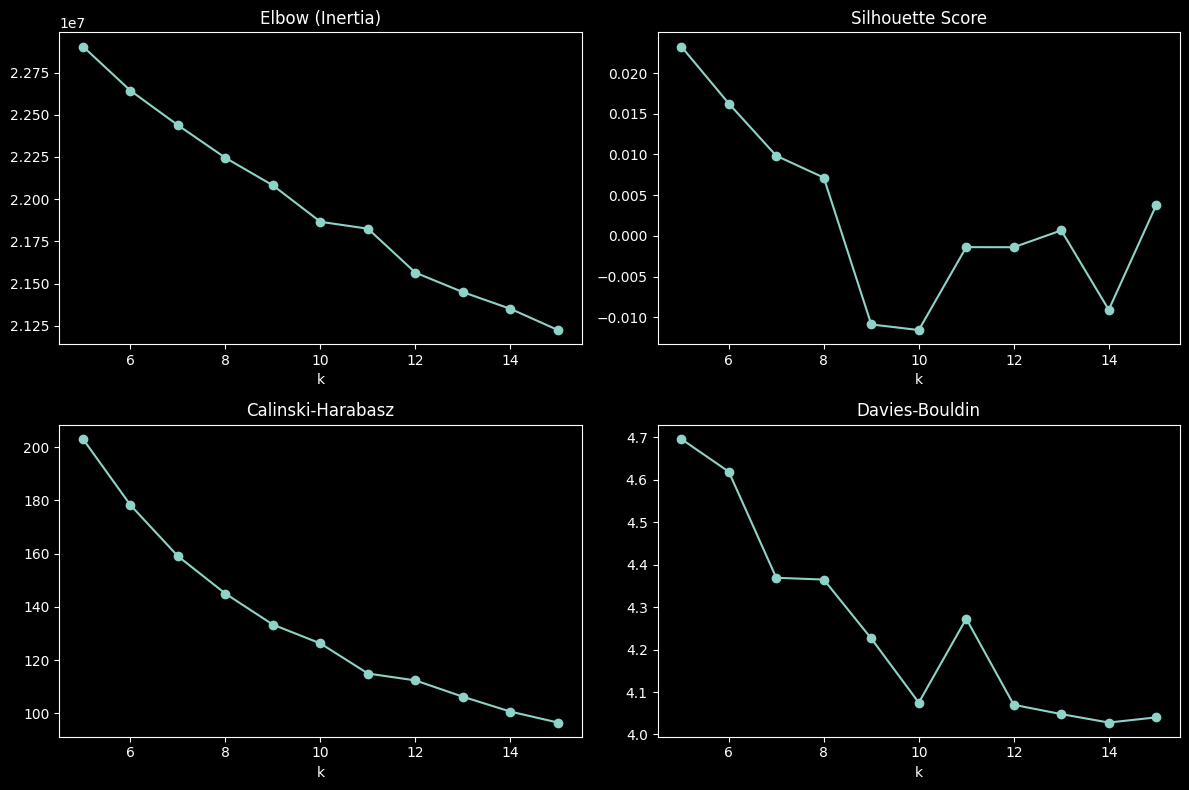

In [92]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Inertia
axes[0, 0].plot(scores_df["k"], scores_df["inertia"], marker="o")
axes[0, 0].set_title("Elbow (Inertia)")
axes[0, 0].set_xlabel("k")

# Silhouette
axes[0, 1].plot(scores_df["k"], scores_df["silhouette"], marker="o")
axes[0, 1].set_title("Silhouette Score")
axes[0, 1].set_xlabel("k")

# Calinski-Harabasz
axes[1, 0].plot(scores_df["k"], scores_df["calinski_harabasz"], marker="o")
axes[1, 0].set_title("Calinski-Harabasz")
axes[1, 0].set_xlabel("k")

# Davies-Bouldin
axes[1, 1].plot(scores_df["k"], scores_df["davies_bouldin"], marker="o")
axes[1, 1].set_title("Davies-Bouldin")
axes[1, 1].set_xlabel("k")

plt.tight_layout()
plt.show()

1. Inertia
- Плавное убывание без явного локтя.
- Небольшое замедление примерно после: k ≈ 9–10
2. Silhouette
- максимум в этом диапазоне — k=5, дальше быстрое падение
- при k ≥ 9 — уже около 0 или отрицательные
3. Davies-Bouldin
- Лучшие значения (минимум) около: k = 10, k = 12–14
4. Calinski-Harabasz
- Постепенное снижение.
- Максимум снова при k=5.

С учётом того, что silhouette положительный только до 8, DB улучшается до 10, inertia замедляется после 9, то разумный рабочий диапазон: k = 6–9

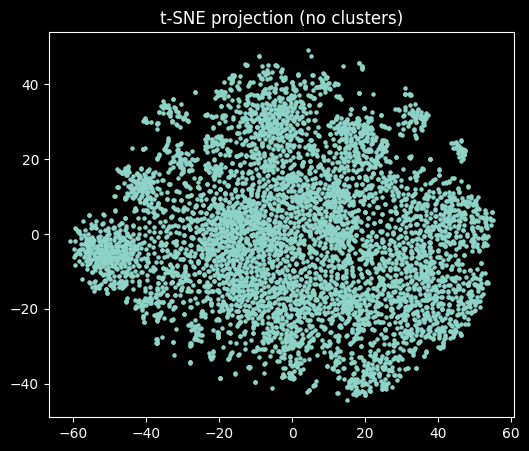

In [93]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_2d = tsne.fit_transform(X_clust)

plt.figure(figsize=(6,5))
plt.scatter(X_2d[:,0], X_2d[:,1], s=5)
plt.title("t-SNE projection (no clusters)")
plt.show()

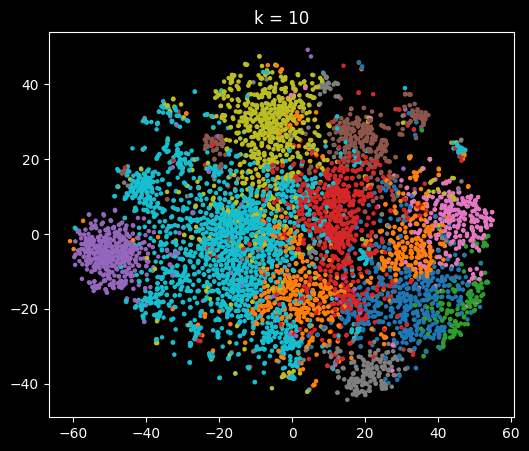

In [94]:
for k in range(6, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = kmeans.fit_predict(X_clust)

    plt.figure(figsize=(6,5))
    plt.scatter(X_2d[:,0], X_2d[:,1], c=labels, s=5, cmap="tab10")
    plt.title(f"k = {k}")
    plt.show()

In [95]:
from sklearn.cluster import KMeans

k = 8
kmeans8 = KMeans(n_clusters=k, random_state=42, n_init="auto")
labels8 = kmeans8.fit_predict(X_clust)

df_users["cluster_k8"] = labels8

In [96]:
cluster_k8_sizes = df_users["cluster_k8"].value_counts().sort_index()
cluster_k8_sizes

cluster_k8
0     605
1     755
2     163
3     961
4     463
5     911
6     313
7    1869
Name: count, dtype: int64

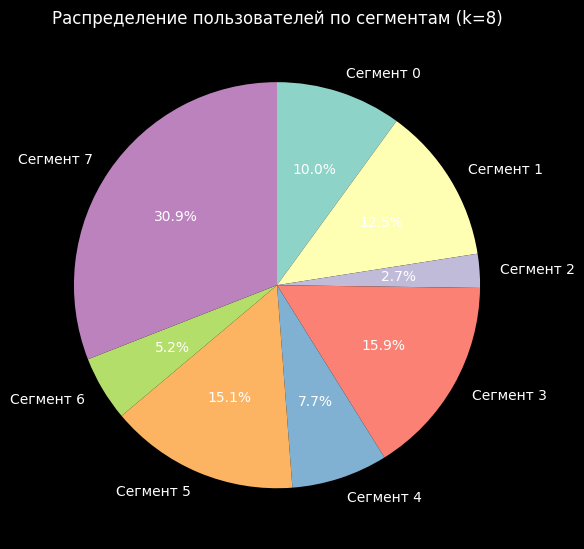

In [97]:
plt.figure(figsize=(6, 6))
plt.pie(
    cluster_k8_sizes,
    labels=[f"Сегмент {i}" for i in cluster_k8_sizes.index],
    autopct="%.1f%%",
    startangle=90,
    counterclock=False
)

plt.title("Распределение пользователей по сегментам (k=8)")
plt.tight_layout()
plt.show()

# Профили пользователей кластеров по поведенческим данным

In [98]:
behavior_cols = [
    "num_ratings",
    "mean_rating",
    "std_rating",
    "median_rating",
    "min_rating",
    "max_rating",
    "rating_entropy",
    "mean_year",
    "std_year",
    "min_year",
    "max_year",
    "mean_imdb",
    "std_imdb",
]

cluster_behavior = (
    df_users.groupby("cluster_k8")[behavior_cols]
    .mean()
    .sort_index()
)

cluster_behavior

,num_ratings,mean_rating,std_rating,median_rating,min_rating,max_rating,rating_entropy,mean_year,std_year,min_year,max_year,mean_imdb,std_imdb
cluster_k8,,,,,,,,,,,,,
0,352.418182,3.509522,1.020121,3.614876,1.038017,4.998347,0.835124,1989.480992,10.342157,1939.441322,1999.933884,6.955668,0.894143
1,202.109934,3.743712,0.980514,3.868212,1.128477,5.000000,0.801836,1988.735099,11.443980,1941.108609,1999.864901,7.345555,0.733543
2,825.226994,3.485675,1.012523,3.601227,1.006135,5.000000,0.835333,1987.619632,12.578271,1930.251534,1999.981595,6.846397,0.921229
3,116.339230,3.669920,1.009249,3.784599,1.283039,4.997919,0.802412,1986.433923,11.678003,1944.529657,1999.693028,7.174503,0.874277
4,58.090713,3.575063,1.064526,3.707343,1.269978,4.987041,0.829041,1993.239741,9.599870,1956.825054,1999.859611,7.006484,0.908586
5,76.127333,3.944025,0.941368,4.095499,1.529089,4.997805,0.734758,1976.043908,18.214841,1934.519210,1999.244786,7.636044,0.685567
6,459.929712,3.684348,0.976126,3.814696,1.086262,5.000000,0.803722,1981.188498,16.204432,1928.223642,1999.900958,7.303037,0.748026
7,51.386303,3.712109,1.034216,3.865704,1.387373,4.989834,0.793863,1990.176030,10.247609,1954.810059,1999.658641,7.333543,0.822692


#### Кластер 1 — Активные массовые зрители

- num_ratings = 352
- mean_rating = 3.51
- rating_entropy = 0.835

Довольно активные, смотрят много. Ставят умеренные оценки.

#### Кластер 2 — Драматические ценители качества

- num_ratings = 202
- mean_rating = 3.74
- mean_imdb = 7.35

Менее активны, но выше оценивают. Выбирают более качественные фильмы (IMDb высокий).

#### Кластер 3 — Универсальный heavy-user

- num_ratings = 825
- mean_rating = 3.49
- mean_imdb = 6.85
- rating_entropy = 0.835
- std_year = 12.57 (широкий диапазон эпох)

Самые активные пользователи. Смотрят фильмы разного качества (низкий средний IMDb + высокий std). Большой разброс по эпохам.

#### Кластер 4 — Жанровый умеренный зритель

- num_ratings = 116
- mean_rating = 3.67
- mean_imdb = 7.17
- mean_year = 1986

Менее активны. IMDb выше среднего. Более избирательный профиль.

#### Кластер 5 — Современная аудитория

- num_ratings = 58
- mean_year = 1993 (самый высокий)
- mean_rating = 3.58
- mean_imdb = 7.00

Смотрят более современные фильмы. Низкая активность. Не выраженный уклон в качество или строгость.

#### Кластер 6 — Киноманы-классики

- num_ratings = 76
- mean_rating = 3.94 (самый высокий)
- mean_imdb = 7.64 (самый высокий)
- mean_year = 1976 (самый старый)
- rating_entropy = 0.73 (самая низкая)

Самый яркий сегмент. Предпочитают старое и признанное кино. Ставят высокие оценки. Используют шкалу менее вариативно.

#### Кластер 7 — Активные ценители качества

- num_ratings = 460
- mean_rating = 3.68
- mean_imdb = 7.30
- mean_year = 1981
- std_year = 16.20

Достаточно активные. Высокий IMDb. Смотрят фильмы разных эпох. Качественный, но не узкий профиль.

#### Кластер 8 — Малый, но избирательный сегмент

- num_ratings = 51
- mean_rating = 3.71
- mean_imdb = 7.33
- mean_year = 1990

Низкая активность. Выбирают фильмы более высокого качества. Скорее редкие, но осознанные зрители.

# Профили пользователей кластеров по вкусовым предпочтениям

In [99]:
genre_share_cols = [c for c in df_users.columns if c.startswith("genre_share__")]

cluster_genres = df_users.groupby("cluster_k8")[genre_share_cols].mean().sort_index()

top_genres = {}
for cl in cluster_genres.index:
    top_genres[cl] = cluster_genres.loc[cl].sort_values(ascending=False).head(5)

top_genres_df = pd.DataFrame(top_genres).T
top_genres_df

,genre_share__Action,genre_share__Adventure,genre_share__Comedy,genre_share__Drama,genre_share__Romance,genre_share__Sci-Fi,genre_share__Thriller
0,0.140754,NaN,0.187442,0.133051,NaN,0.075086,0.092186
1,0.085921,NaN,0.192248,0.248009,0.094239,NaN,0.081375
2,0.122109,NaN,0.182659,0.157449,0.070169,NaN,0.090156
3,0.193178,0.097652,0.090915,NaN,NaN,0.150692,0.106000
4,0.104292,NaN,0.212302,0.186189,NaN,0.067052,0.117373
5,0.079896,NaN,0.144184,0.208138,0.076996,NaN,0.077206
6,0.091471,NaN,0.172822,0.218107,0.079542,NaN,0.079319
7,0.112613,NaN,0.193229,0.198484,0.079138,NaN,0.090303


#### Кластер 1 — Лёгкий развлекательный профиль

- Comedy = 0.187
- Action = 0.141
- Drama = 0.133
- Thriller = 0.092

Умеренно развлекательная аудитория. Комедии и экшен выше среднего, драма не доминирует.

#### Кластер 2 — Драматико-романтический

- Drama = 0.248
- Comedy = 0.192
- Romance = 0.094
- Action = 0.086

Самый “эмоциональный” сегмент. Драма выражена сильнее всего.

#### Кластер 3 — Смешанный умеренный

- Comedy = 0.183
- Drama = 0.157
- Action = 0.122
- Thriller = 0.090

Без яркого перекоса. Сбалансированный, но менее выраженный, чем массовый сегмент.

#### Кластер 4 — Экшен / Sci-Fi ядро

- Action = 0.193
- Sci-Fi = 0.151 (максимум)
- Thriller = 0.106
- Comedy = 0.091

Самый жанрово выраженный кластер. Любят динамику и фантастику.

#### Кластер 5 — Комедия + Триллер

- Comedy = 0.212
- Drama = 0.186
- Thriller = 0.117
- Action = 0.104

Развлекательный, но с элементами напряжения.

#### Кластер 6 — Серьёзная драма

- Drama = 0.208
- Comedy = 0.144
- Action = 0.080

Драма доминирует, экшен выражен слабо. Более “вдумчивый” профиль.

#### Кластер 7 — Драматический сбалансированный

- Drama = 0.218
- Comedy = 0.173
- Action = 0.091

Похож на 5, но чуть более универсален.

#### Кластер 8 — Массовое ядро

- Comedy = 0.193
- Drama = 0.198
- Action = 0.113
- Thriller = 0.090

Самый большой сегмент (1869 пользователей). Сбалансированный вкус без яркого жанрового перекоса.

In [119]:
country_cols = [c for c in df_users.columns if c.startswith("country_share__")]

cluster_country = df_users.groupby("cluster_k8")[country_cols].mean()

for cl in cluster_country.index:
    print(f"\nCluster {cl}")
    print(cluster_country.loc[cl].sort_values(ascending=False).head(5))


Cluster 0
country_share__United States     0.712794
country_share__United Kingdom    0.107000
country_share__France            0.031050
country_share__Germany           0.024630
country_share__Canada            0.024195
Name: 0, dtype: float64

Cluster 1
country_share__United States     0.657343
country_share__United Kingdom    0.128883
country_share__France            0.046716
country_share__Germany           0.027748
country_share__Canada            0.021035
Name: 1, dtype: float64

Cluster 2
country_share__United States     0.696880
country_share__United Kingdom    0.107723
country_share__France            0.035599
country_share__Canada            0.027706
country_share__Germany           0.023081
Name: 2, dtype: float64

Cluster 3
country_share__United States     0.667345
country_share__United Kingdom    0.134306
country_share__France            0.033511
country_share__Canada            0.023076
country_share__Mexico            0.022171
Name: 3, dtype: float64

Cluster 4
country_s

1. Все сегменты преимущественно ориентированы на американское кино.
2. Кластеры 2, 4 и 7 — наиболее “европейские”.
3. Кластер 1 — самый американский.

In [120]:
director_cols = [c for c in df_users.columns if c.startswith("director_share__")]

cluster_director = df_users.groupby("cluster_k8")[director_cols].mean()

for cl in cluster_director.index:
    print(f"\nCluster {cl}")
    print(cluster_director.loc[cl].sort_values(ascending=False).head(5))


Cluster 0
director_share__Steven Spielberg    0.019545
director_share__Richard Donner      0.013899
director_share__Robert Zemeckis     0.012002
director_share__Tim Burton          0.011086
director_share__James Cameron       0.010978
Name: 0, dtype: float64

Cluster 1
director_share__Steven Spielberg    0.020872
director_share__Rob Reiner          0.013756
director_share__Woody Allen         0.012370
director_share__Robert Zemeckis     0.010316
director_share__Tim Burton          0.010302
Name: 1, dtype: float64

Cluster 2
director_share__Steven Spielberg    0.013179
director_share__Richard Donner      0.011124
director_share__Ron Howard          0.009079
director_share__Tim Burton          0.008122
director_share__Robert Zemeckis     0.007818
Name: 2, dtype: float64

Cluster 3
director_share__Steven Spielberg    0.041206
director_share__James Cameron       0.028040
director_share__Robert Zemeckis     0.017678
director_share__Ridley Scott        0.017201
director_share__Richard Donne

#### Кластер 1

1. Steven Spielberg = 1.95%
2. Richard Donner = 1.39%
3. Robert Zemeckis = 1.20%

Классический голливудский мейнстрим 80–90-х. Приключенческое и развлекательное кино.

#### Кластер 2

1. Steven Spielberg = 2.09%
2. Rob Reiner = 1.38%
3. Woody Allen = 1.24%

Более “интеллигентный” мейнстрим. Присутствует Вуди Аллен — лёгкий уклон в авторское и диалоговое кино.

#### Кластер 3

1. Steven Spielberg = 1.32%
2. Richard Donner = 1.11%
3. Ron Howard = 0.91%

Универсальный голливудский профиль без выраженного авторского акцента.

### Кластер 4

1. Steven Spielberg = 4.12%
2. James Cameron = 2.80%
3. Ridley Scott = 1.72%

Самый ярко выраженный блокбастерный сегмент. Sci-Fi и крупные студийные режиссёры.

#### Кластер 5

1. Jay Roach = 1.71%
2. John Lasseter = 1.60%
3. James Cameron = 1.36%

Более лёгкий, комедийно-анимационный профиль. Pixar и массовое кино.

#### Кластер 6

1. Alfred Hitchcock = 3.32%
2. Steven Spielberg = 2.84%
3. Francis Ford Coppola = 1.80%
4. John Huston = 1.58%

Самый “классический” сегмент. Явный интерес к режиссёрам золотого фонда.

#### Кластер 7

1. Alfred Hitchcock = 2.03%
2. Woody Allen = 1.42%
3. Stanley Kubrick = 0.95%
4. Coppola = 0.92%

Интеллектуально-авторский профиль. Более артхаусное и философское кино.

#### Кластер 8

1. Steven Spielberg = 3.40%
2. James Cameron = 1.68%
3. Rob Reiner = 1.60%

Массовый англоязычный мейнстрим без сильного уклона в классику или артхаус.

In [121]:
actor_cols = [c for c in df_users.columns if c.startswith("actor_share__")]

cluster_actor = df_users.groupby("cluster_k8")[actor_cols].mean()

for cl in cluster_actor.index:
    print(f"\nCluster {cl}")
    print(cluster_actor.loc[cl].sort_values(ascending=False).head(5))


Cluster 0
actor_share__Harrison Ford            0.008801
actor_share__Tom Hanks                0.007645
actor_share__Mel Gibson               0.006215
actor_share__Arnold Schwarzenegger    0.005951
actor_share__Bruce Willis             0.005684
Name: 0, dtype: float64

Cluster 1
actor_share__Tom Hanks         0.008268
actor_share__Harrison Ford     0.008241
actor_share__Robert De Niro    0.007606
actor_share__Al Pacino         0.005519
actor_share__Tom Cruise        0.005328
Name: 1, dtype: float64

Cluster 2
actor_share__Harrison Ford     0.005945
actor_share__Tom Hanks         0.005354
actor_share__Mel Gibson        0.005178
actor_share__Robert De Niro    0.005016
actor_share__Gene Hackman      0.004856
Name: 2, dtype: float64

Cluster 3
actor_share__Harrison Ford            0.018141
actor_share__Arnold Schwarzenegger    0.011763
actor_share__Sigourney Weaver         0.008832
actor_share__Carrie Fisher            0.008727
actor_share__Mark Hamill              0.008365
Name: 3, dtype

#### Кластер 1

1. Harrison Ford = 0.88%
2. Tom Hanks = 0.76%
3. Arnold Schwarzenegger = 0.60%
4. Bruce Willis = 0.57%

Классический экшен-мейнстрим 80–90-х. Голливудские герои, приключения, боевики.

#### Кластер 2

1. Tom Hanks = 0.83%
2. Harrison Ford = 0.82%
3. Robert De Niro = 0.76%
4. Al Pacino = 0.55%

Более драматический и актёрский сегмент. Сильные актёрские роли, криминальная и социальная драма.

#### Кластер 3

1. Harrison Ford = 0.59%
2. Tom Hanks = 0.54%
3. Mel Gibson = 0.52%
4. Robert De Niro = 0.50%

Универсальный массовый профиль. Без выраженной специализации — классический голливудский набор.

#### Кластер 4

1. Harrison Ford = 1.81%
2. Arnold Schwarzenegger = 1.18%
3. Sigourney Weaver = 0.88%
4. Carrie Fisher = 0.87%
5. Mark Hamill = 0.84%

Самый яркий sci-fi/франшизный сегмент. Star Wars, Alien, боевики и культовая фантастика.

#### Кластер 5

1. Kevin Spacey = 1.06%
2. Bill Murray = 0.89%
3. John Cusack = 0.71%

Более “интеллектуально-комедийный” профиль. Драмеди и ироничное кино 90-х.

#### Кластер 6

1. Harrison Ford = 1.24%
2. Humphrey Bogart = 0.89%
3. Cary Grant = 0.71%
4. Al Pacino = 0.71%

Самый “классический” сегмент. Золотой Голливуд + культовая драма.

#### Кластер 7

1. Robert De Niro = 0.64%
2. Jack Nicholson = 0.56%
3. Gene Hackman = 0.48%

Авторско-драматический профиль. Сильные актёрские работы, серьёзное кино.

#### Кластер 8

1. Harrison Ford = 1.25%
2. Tom Hanks = 1.19%
3. Kevin Spacey = 0.87%

📌 Массовый, но с уклоном в качественную драму. Баланс экшена и серьёзных ролей.

# Профили пользователей по демографическим данным

In [100]:
df_users = df_users.merge(
    users,
    on="user_id",
    how="left"
)

In [101]:
df_users[["user_id", "cluster_k8", "gender", "occupation", "age_group_id"]].head()

,user_id,cluster_k8,gender,occupation,age_group_id
0,1,5,F,11,1
1,2,1,M,17,7
2,3,7,M,16,3
3,4,3,M,8,5
4,5,1,M,21,3


In [105]:
df_users = df_users.merge(
    age_groups,
    left_on="age_group_id",
    right_on="group_id",
    how="left"
)

df_users = df_users.merge(
    occupations,
    left_on="occupation",
    right_on="occ_id",
    how="left"
)

## Профили пользователей кластеров по полу

In [110]:
gender_dist = pd.crosstab(df_users["cluster_k8"], df_users["gender"], normalize="index")
gender_dist

gender,F,M
cluster_k8,,
0,0.218182,0.781818
1,0.354967,0.645033
2,0.196319,0.803681
3,0.119667,0.880333
4,0.259179,0.740821
5,0.358946,0.641054
6,0.277955,0.722045
7,0.336009,0.663991


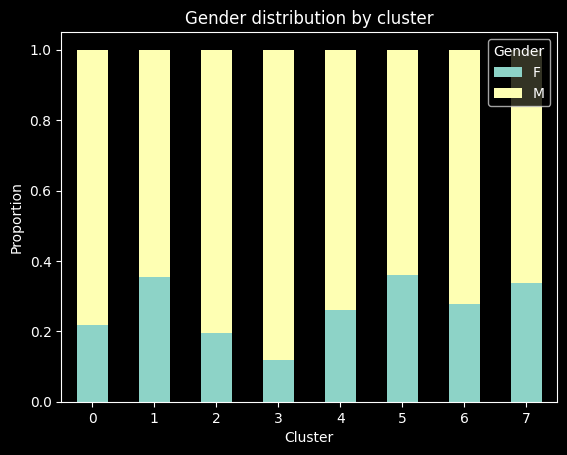

In [111]:
plt.figure(figsize=(8,5))
gender_dist.plot(kind="bar", stacked=True)
plt.title("Gender distribution by cluster")
plt.ylabel("Proportion")
plt.xlabel("Cluster")
plt.legend(title="Gender")
plt.xticks(rotation=0)
plt.show()

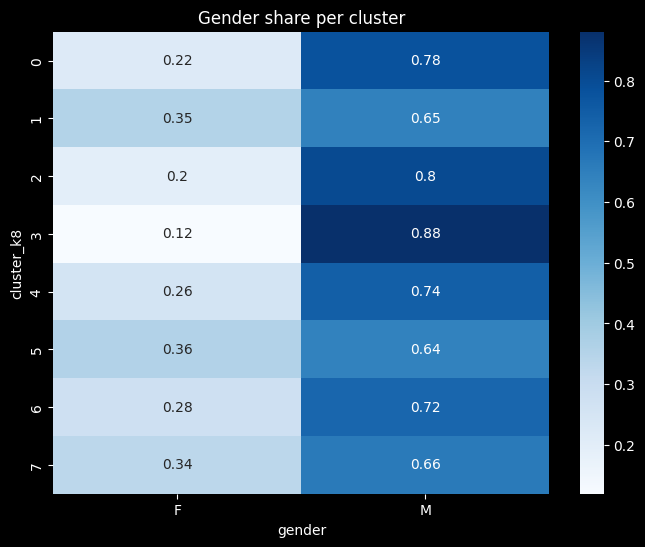

In [117]:
import seaborn as sns

plt.figure(figsize=(8,6))
sns.heatmap(gender_dist, annot=True, cmap="Blues")
plt.title("Gender share per cluster")
plt.show()

Все кластеры преимущественно мужские, но степень различается.
- Самый выраженный гендерный перекос — в кластере 4
- Самый сбалансированный — кластер 6

## Профили пользователей кластеров по возрастной группе

In [112]:
age_dist = pd.crosstab(df_users["cluster_k8"], df_users["group_label"], normalize="index")
age_dist

group_label,18_24,25_34,35_44,45_49,50_55,56_plus,under_18
cluster_k8,,,,,,,
0,0.304132,0.469421,0.132231,0.024793,0.021488,0.003306,0.044628
1,0.140397,0.422517,0.196026,0.090066,0.076821,0.058278,0.015894
2,0.220859,0.478528,0.202454,0.061350,0.018405,0.006135,0.012270
3,0.189386,0.339230,0.223725,0.093652,0.078044,0.039542,0.036420
4,0.257019,0.352052,0.172786,0.045356,0.049676,0.064795,0.058315
5,0.060373,0.196487,0.252470,0.163557,0.147091,0.145993,0.034029
6,0.035144,0.281150,0.303514,0.127796,0.172524,0.067093,0.012780
7,0.219369,0.352595,0.166934,0.084002,0.072766,0.059390,0.044944


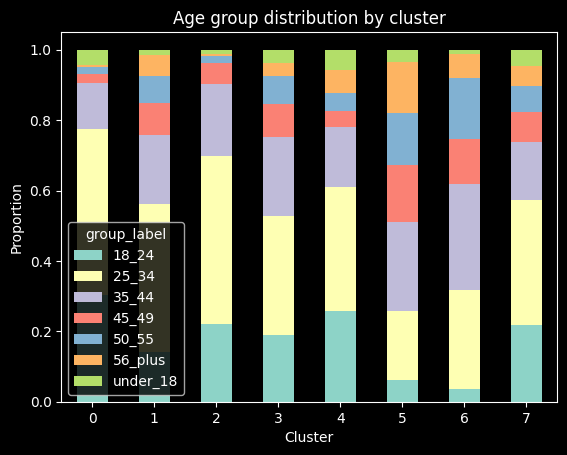

In [113]:
plt.figure(figsize=(10,6))
age_dist.plot(kind="bar", stacked=True)
plt.title("Age group distribution by cluster")
plt.ylabel("Proportion")
plt.xlabel("Cluster")
plt.xticks(rotation=0)
plt.show()

#### Кластер 1
Почти 82% пользователей младше 35 лет (18–24 = 30%, 25–34 = 47%). Самый молодой сегмент с минимальной долей 45+

#### Кластер 2
Почти 58% до 35 лет, но уже заметная доля старших: 45+ ≈ 22%. Сбалансированный возрастной профиль без крайностей.

#### Кластер 3
Почти 71% младше 35 лет (доминирует 25–34 = 48%). Молодой сегмент, но с умеренным присутствием 35–44.

#### Кластер 4
Возраст распределён относительно равномерно: 25–34 = 34%, 35–44 = 22%, 45+ ≈ 21%. Один из самых сбалансированных по возрасту кластеров.

#### Кластер 5
Около 61% младше 35 лет, но доля 45+ уже ≈ 16%. Молодой сегмент с лёгким смещением к более старшим возрастам.

#### Кластер 6
Самый возрастной сегмент: 45+ ≈ 46%, при этом 18–24 всего 6%. Чётко выраженная аудитория старшего возраста.

#### Кластер 7
Преобладают пользователи 35+ (≈ 67%), особенно 35–44 (30%) и 50–55 (17%). Зрелый возрастной профиль.

#### Кластер 8
Почти 62% младше 35 лет, но доля 45+ уже около 22%. Умеренно молодой сегмент без резкого перекоса.

## Профили пользователей кластеров по профессиям

In [109]:
pd.crosstab(df_users["cluster_k8"], df_users["occ_name"], normalize="index")

occ_name,Academic/Educator,Artist,Clerical/Admin,College/Grad student,Customer Service,Doctor/Health care,Executive/Managerial,Farmer,Homemaker,K-12 student,...,Other,Programmer,Retired,Sales/Marketing,Scientist,Self-employed,Technician/engineer,Tradesman/craftsman,Unemployed,Writer
cluster_k8,,,,,,,,,,,,,,,,,,,,,
0,0.054545,0.039669,0.034711,0.196694,0.038017,0.024793,0.090909,0.004959,0.006612,0.038017,...,0.123967,0.067769,0.000000,0.049587,0.024793,0.042975,0.087603,0.011570,0.019835,0.031405
1,0.105960,0.055629,0.035762,0.121854,0.009272,0.037086,0.095364,0.000000,0.011921,0.015894,...,0.116556,0.062252,0.021192,0.055629,0.033113,0.049007,0.054305,0.009272,0.010596,0.072848
2,0.049080,0.061350,0.030675,0.128834,0.030675,0.042945,0.098160,0.006135,0.018405,0.012270,...,0.177914,0.024540,0.000000,0.055215,0.012270,0.042945,0.061350,0.030675,0.018405,0.073620
3,0.058273,0.037461,0.016649,0.124870,0.022893,0.026015,0.114464,0.002081,0.004162,0.038502,...,0.115505,0.097815,0.018730,0.053070,0.026015,0.032258,0.136316,0.014568,0.011446,0.032258
4,0.066955,0.034557,0.028078,0.177106,0.017279,0.038877,0.092873,0.004320,0.008639,0.053996,...,0.101512,0.069114,0.030238,0.051836,0.023758,0.041037,0.090713,0.012959,0.008639,0.038877
5,0.135016,0.050494,0.037322,0.050494,0.010977,0.034029,0.125137,0.003293,0.025247,0.023052,...,0.106476,0.052689,0.055982,0.038419,0.028540,0.043908,0.073546,0.008782,0.012075,0.050494
6,0.127796,0.079872,0.038339,0.051118,0.012780,0.060703,0.118211,0.000000,0.012780,0.006390,...,0.127796,0.044728,0.015974,0.031949,0.015974,0.067093,0.044728,0.006390,0.012780,0.089457
7,0.084002,0.036383,0.024077,0.140717,0.017657,0.049759,0.124131,0.003210,0.021937,0.039058,...,0.119850,0.057785,0.020332,0.054040,0.018727,0.032103,0.077047,0.011236,0.010166,0.038523


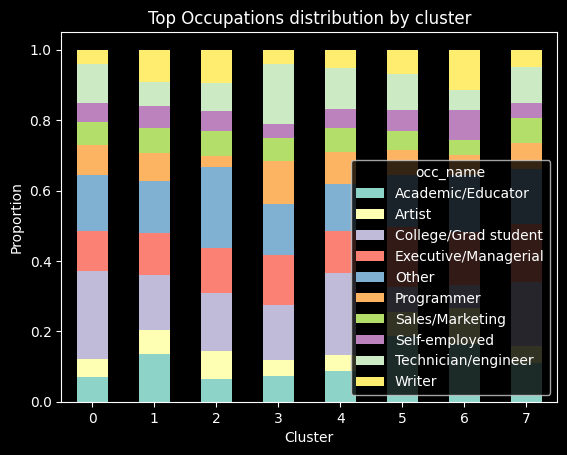

In [115]:
top_occupations = df_users["occ_name"].value_counts().head(10).index

occ_filtered = df_users[df_users["occ_name"].isin(top_occupations)]

occ_dist = pd.crosstab(
    occ_filtered["cluster_k8"],
    occ_filtered["occ_name"],
    normalize="index"
)

plt.figure(figsize=(12,6))
occ_dist.plot(kind="bar", stacked=True)
plt.title("Top Occupations distribution by cluster")
plt.ylabel("Proportion")
plt.xlabel("Cluster")
plt.xticks(rotation=0)
plt.show()

#### Кластер 1
Наиболее представлены студенты вузов и аспиранты (19.7%), также заметны руководители и менеджеры (9.1%) и техники/инженеры (8.8%). Профиль преимущественно студенческо-технический.

#### Кластер 2
Выделяется высокая доля преподавателей и работников образования (10.6%), а также писателей (7.3%) и руководителей (9.5%). Более выраженный академико-гуманитарный профиль.

#### Кластер 3
Самая высокая доля категории «Другое» (17.8%), при заметной доле руководителей и менеджеров (9.8%). Профессионально наиболее разнородный сегмент.

#### Кластер 4
Самая высокая доля техников и инженеров (13.6%) и повышенная доля программистов (9.8%), также много руководителей (11.4%). Чётко выраженный техническо-инженерный профиль.

#### Кластер 5
Высокая доля студентов вузов (17.7%), также заметны техники/инженеры (9.1%) и руководители (9.3%). Молодой, частично технический сегмент.

#### Кластер 6
Самая высокая доля преподавателей и работников образования (13.5%), высокая доля руководителей (12.5%), а также заметная доля пенсионеров (5.6%). Более зрелый и академически ориентированный профиль.

#### Кластер 7
Высокая доля преподавателей (12.8%), значительная доля писателей (8.9%) и руководителей (11.8%). Интеллектуально-гуманитарный профиль.

#### Кластер 8
Заметны руководители (12.4%) и студенты вузов (14.1%), также присутствуют техники/инженеры (7.7%). Сбалансированный управленческо-студенческий профиль.

## Резюмируем

### Кластер 1 — Молодой массовый экшен-сегмент

- 82% младше 35 лет, 78% мужчины
- Высокая доля студентов (19.7%) и технических профессий.
- Ориентация на США (71%) и классический голливудский мейнстрим (Spielberg, Donner, Zemeckis; Harrison Ford, Schwarzenegger).
- Активные пользователи (≈352 оценок)
- Смотрят в основном развлекательное кино 80–90-х.

### Кластер 2 — Сбалансированные ценители драмы

- 58% до 35 лет, но 45+ уже ≈22%
- Гендер более сбалансирован.
- Повышенная доля преподавателей (10.6%) и писателей (7.3%).
- Более европейская ориентация (Великобритания 12.9%, Франция 4.7%).
- Более высокий IMDb (7.35) и средняя оценка (3.74) — склонность к качественному драматическому кино.

### Кластер 3 — Универсальные heavy-users

- Самая высокая активность (≈825 оценок)
- 71% до 35 лет, 80% мужчины.
- Профессионально разнородный сегмент (Other 17.8%).
- США ≈70%, классический голливудский набор актёров.
- Низкий средний IMDb (6.85) и высокая энтропия — широкий, неузкоспециализированный стиль потребления.

### Кластер 4 — Мужской sci-fi / франшизный сегмент

- 88% мужчины, возраст распределён равномерно (25–44 доминирует).
- Высокая доля инженеров (13.6%) и программистов (9.8%).
- Максимальная доля Spielberg (4.1%) и Cameron (2.8%); актёры Ford (1.81%), Schwarzenegger, Weaver.
- Самый выраженный блокбастерный и фантастический профиль.

### Кластер 5 — Молодой развлекательно-комедийный

- 61% до 35 лет.
- Много студентов (17.7%), заметны инженеры (9.1%).
- Повышенная доля Германии (5.6%).
- Режиссёры Jay Roach, Lasseter — более лёгкий, частично семейный контент.
- Умеренная активность и современная ориентация (mean_year ≈1993).

### Кластер 6 — Возрастные киноманы-классики

- Самый возрастной: 45+ ≈46%. Более сбалансирован по полу.
- Высокая доля преподавателей (13.5%) и менеджеров (12.5%), есть пенсионеры (5.6%).
- Самый высокий IMDb (7.64) и самая высокая средняя оценка (3.94)
- Самый старый средний год (1976).
- Hitchcock, Coppola, Bogart — ярко выраженная ориентация на классику.

### Кластер 7 — Зрелый интеллектуальный сегмент

- 35+ 67%.
- Высокая доля преподавателей (12.8%) и писателей (8.9%).
- Более европейская направленность (Франция 4.2%).
- Hitchcock, Kubrick, De Niro. Серьёзное, авторское кино
- Высокий IMDb (7.30) и умеренно высокая активность (≈460 оценок).

### Кластер 8 — Массовый сбалансированный мейнстрим

- 62% до 35 лет, но 45+ уже ≈22%.
- Руководители (12.4%) и студенты (14.1%).
- США ≈70%. Spielberg, Hanks, De Niro.
- Низкая активность (≈51 оценка), но относительно высокий IMDb (7.33).
- Сбалансированный вкус без яркого перекоса.